# Statistical Foundations for Finance - Take Home 2

## Setup and Data Loading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, optimize, integrate
from scipy.special import ndtr
from sklearn.mixture import GaussianMixture

returns = pd.read_csv("DJIA30stockreturns.csv", header=None)

print(f"Data shape: {returns.shape}")
# Shoudl be (8000, 25)
print(f"First few rows: \n{returns.head()}")

Data shape: (8000, 25)
First few rows: 
         0         1         2         3         4         5         6   \
0  0.668899  1.055193  2.409755  1.047484 -1.633642  0.216216  0.317377   
1  0.346067 -1.055193 -0.397615  0.419288 -1.302564 -0.112374  0.684213   
2  0.318387 -0.445371 -1.396155 -0.621172 -1.501079  0.328124 -1.346555   
3  0.660068 -0.727276  1.188769 -0.642003  0.948302  0.849827 -0.988388   
4 -0.978456 -2.214113 -1.188769 -0.646151 -0.751883 -0.102731 -2.721256   

         7         8         9   ...        15        16        17        18  \
0  0.883838 -2.817088  0.400001  ...  0.561799 -2.247286  0.351494 -0.170358   
1  1.136433  2.120221  0.216001  ...  2.893311 -2.057383  1.559703 -1.980263   
2 -0.250313 -0.701757 -1.051148  ... -2.479602  2.962367 -0.860399 -1.828204   
3  0.619630  1.398624  1.663378  ...  1.528100 -0.451468 -0.881926  1.828204   
4 -1.001310  2.739897 -3.133372  ... -0.275103 -1.826535 -2.131671  0.000000   

         19        20       

## **1. Model Density Functions**

### 1.1 Gaussian Distribution

In [ ]:
def gaussian_pdf(x, mu, sigma):
    return stats.norm.pdf(x, loc=mu, scale=sigma)

# We could compute this analytically (mu_hat = mean(data) sigma_hat = std.(data))
# but for consistency with other models, let's keep MLE structure

def gaussian_loglik(params, data):
    """Negative log_likelihood for optimization"""
    mu, sigma = params
    if sigma <= 0:
        return np.inf
    return -np.sum(stats.norm.logpdf(data, loc=mu, scale=sigma))

def fit_gaussian(data):
    """Fit Gaussian via MLE"""
    mu_init = np.mean(data)
    sigma_init = np.std(data)

    result = optimize.minimize(
        gaussian_loglik,
        x0 = [mu_init, sigma_init],
        args = (data, ),
        method = 'L-BFGS-B',
        bounds = [(-np.inf, np.inf), (1e-6, np.inf)]
    )

    return result.x, -result.fun # params, log-likelihood

### 1.2 Mixture of Gaussians

In [ ]:
def mixture_gaussian_pdf(x, params, K):
    """
    PDF of K-component Guassian mixture
    params: [w1, ..., w_{K-1}, mu1, ..., muK, sigma1, ..., sigmaK]
    weights are constrained to sum to 1
    """
    assert len(params) == 3*K - 1

    weights = np.zeros(K)
    weights[:-1] = params[:K-1]
    weights[-1] = 1 - np.sum(weights[:-1])

    mus = params[K-1: 2*K-1]
    sigmas = params[2*K-1: 3*K-1]

    pdf = np.zeros_like(x)
    for i in range(K):
        pdf += weights[i] * stats.norm.pdf(x, loc=mus[i], scale=sigmas[i])

    return pdf

def mixture_gaussian_loglik(params, data, K):
    """Negative log_likelihood for K-component Gaussian mixture"""
    assert len(params) == 3*K - 1

    weights = np.zeros(K)
    weights[:-1] = params[:K-1]
    weights[-1] = 1 - np.sum(weights[:-1])

    # Check constraints
    if np.any(weights <= 1e-3) or np.any(weights >= 1 - 1e-3): # stricter constraints
        return np.inf
    if not np.isclose(np.sum(weights), 1.0, atol=1e-6):  # Ensure they sum to 1
        return np.inf

    mus = params[K-1: 2*K-1]
    sigmas = params[2*K-1: 3*K-1]

    if np.any(sigmas <= 1e-3):
        return np.inf

    # Compute log-likelihood
    pdf_vals = mixture_gaussian_pdf(data, params, K)

    # Add small epsilon to prevent log(0)
    pdf_vals = np.maximum(pdf_vals, 1e-300)

    if np.any(pdf_vals <= 0) or np.any(~np.isfinite(pdf_vals)):
        return np.inf

    log_lik = np.sum(np.log(pdf_vals))

    if not np.isfinite(log_lik):
        return np.inf

    return -log_lik

def fit_mixture_gaussian(data, K):
    """Fit K-component Gaussian mixture via MLE"""
    # Use sklearn for inititalization
    # could do it ourselves but this is easier
    gmm = GaussianMixture(n_components=K, random_state=42, max_iter=100) #runs EM internally
    gmm.fit(data.reshape(-1, 1))

    # Extract initial params
    weights_init = gmm.weights_[:-1]
    mus_init = gmm.means_.flatten()
    sigmas_init = np.sqrt(gmm.covariances_).flatten()

    x0 = np.concatenate([weights_init, mus_init, sigmas_init])

    # Set up bounds
    bounds = []
    for i in range(K-1): # weights
        bounds.append((1e-6, 1 - 1e-6))
    for i in range(K): # means
        bounds.append((-np.inf, np.inf))
    for i in range(K): # sigmas
        bounds.append((1e-6, np.inf))

    result = optimize.minimize(
        mixture_gaussian_loglik,
        x0 = x0,
        args = (data, K),
        method = 'L-BFGS-B',
        bounds = bounds
    )

    return result.x, -result.fun # params, log-likelihood

### 1.3 Weighted Sum of Chi-Squared(1) with Location

In [ ]:
# ### Characteristic Function Approach

TMAX = 50.0   # may need to play with this
N_T  = 2000   # number of points in t-grid
t_grid = np.linspace(0.0, TMAX, N_T)
dt = t_grid[1] - t_grid[0]

def weighted_chisq_cf_grid(weights, location):
    """
    Characteristic function of weighted sum of chi-squared(1) + location
    X = location + sum(weights[k] * Z_k) where Z_k ~chi^2(1)

    CF of chi^2(1): (1 - 2it)^(-1/2)

    Returns: phi(t_grid) - shape (N_T,)
    """
    phi = np.exp(1j * t_grid * location)
    for w in weights:
        phi *= (1 - 2j * t_grid * w) ** (-0.5)
    return phi

def weighted_chisq_pdf_from_phi(x_array, phi):
    """
    Given data x_array (shape (n, )) and phi(t_grid),
    approximate the pdf at all x via numeric integration.

    Uses Gil-Pelaez formula:
    f(x) = (1/π) * Re[ ∫_0^∞ exp(-itx) * φ(t) dt ]
    """
    x_array = np.asarray(x_array)
    # phase shape: (n_data, N_T)
    phase = np.exp(-1j * np.outer(x_array, t_grid))
    # integrand shape: (n_data, N_T)
    integrand = phase * phi  # broadcasts phi across rows
    # Trapezoidal rule approximation
    # First and last points get weight 0.5
    weights = np.ones(N_T)
    weights[0] = weights[-1] = 0.5
    vals = np.real(np.sum(integrand * weights, axis=1) * dt)
    return vals / np.pi

def weighted_chisq_loglik(params, data, K):
    """Negative log-likelihood"""
    weights = params[:K]
    location = params[K]

    if np.any(weights <= 0):
        return np.inf

    # Check weights are reasonable (avoid numerical issues)
    if np.any(weights > 100):  # arbitrary large bound
        return np.inf

    # Compute CF once for these parameters
    phi = weighted_chisq_cf_grid(weights, location)

    # Evaluate PDF at all data points via CF inversion
    pdf_vals = weighted_chisq_pdf_from_phi(data, phi)

    if np.any(pdf_vals <= 0) or np.any(~np.isfinite(pdf_vals)):
        return np.inf

    return -np.sum(np.log(pdf_vals))


def fit_weighted_chisq(data, K):
    """Fit weighted chi-squared model via MLE"""
    # Initialize weights uniformly, location near zero
    weights_init = np.ones(K) / K
    location_init = np.mean(data)

    x0 = np.concatenate([weights_init, [location_init]])

    bounds = [(1e-6, np.inf) for _ in range(K)] + [(-np.inf, np.inf)]

    result = optimize.minimize(
        weighted_chisq_loglik,
        x0 = x0,
        args = (data, K),
        method = 'L-BFGS-B',
        bounds = bounds,
        options = {'maxiter': 100} # limit due to CF inversion
    )

    return result.x, -result.fun # params, log-likelihood

In [ ]:
# TEMPORARY: faster version putting the returns into bins and working with midpoints and counts

def make_binned_data(data, n_bins=200):
    """
    Bin data into n_bins and return bin midpoints and counts.
    Only bins with nonzero counts are returned.
    """
    counts, edges = np.histogram(data, bins=n_bins)
    mids = 0.5 * (edges[:-1] + edges[1:])
    mask = counts > 0
    return mids[mask], counts[mask]

def weighted_chisq_loglik_binned(params, x_bins, counts, K):
    """
    Negative log-likelihood using binned data.
    x_bins: bin midpoints (length M)
    counts: counts per bin (length M)
    """
    weights = params[:K]
    location = params[K]

    if np.any(weights <= 0) or np.any(weights > 100):
        return np.inf

    # CF on the global t_grid (unchanged)
    phi = weighted_chisq_cf_grid(weights, location)

    # pdf at bin midpoints via CF inversion
    pdf_vals = weighted_chisq_pdf_from_phi(x_bins, phi)

    if np.any(pdf_vals <= 0) or np.any(~np.isfinite(pdf_vals)):
        return np.inf

    # log-likelihood with counts
    loglik = np.sum(counts * np.log(pdf_vals))
    return -loglik

def fit_weighted_chisq_fast(data, K, n_bins=200):
    """
    Fit weighted chi-squared model via binned MLE.
    params: [w1, ..., wK, location]
    """
    x_bins, counts = make_binned_data(data, n_bins=n_bins)

    # Initial guess
    weights_init = np.ones(K) / K
    location_init = np.mean(data)
    x0 = np.concatenate([weights_init, [location_init]])

    bounds = [(1e-6, np.inf) for _ in range(K)] + [(-np.inf, np.inf)]

    result = optimize.minimize(
        weighted_chisq_loglik_binned,
        x0=x0,
        args=(x_bins, counts, K),
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 80}  # can tune further
    )

    return result.x, -result.fun


### 1.4 Location-Scale Noncental t

In [ ]:
def nct_pdf(x, df, nc, loc, scale):
    """PDF of noncentral t-distribution with location and scale"""
    z = (x - loc) / scale
    return stats.nct.pdf(z, df, nc) / scale


def nct_loglik(params, data):
    """Negative log-likelihood"""
    df, nc, loc, scale = params

    if df <= 0 or scale <= 0:
        return np.inf

    pdf_vals = nct_pdf(data, df, nc, loc, scale)
    if np.any(pdf_vals <= 0) or np.any(~np.isfinite(pdf_vals)):
        return np.inf

    log_lik = np.sum(np.log(pdf_vals))
    return -log_lik


def fit_nct(data):
    """Fit noncentral t via MLE"""
    # Initialize
    df_init = 5
    nc_init = 0
    loc_init = np.mean(data)
    scale_init = np.std(data)

    x0 = [df_init, nc_init, loc_init, scale_init]

    bounds = [(0.1, 100), (-10, 10), (-np.inf, np.inf), (1e-6, np.inf)]

    result = optimize.minimize(
        nct_loglik,
        x0 = x0,
        args = (data, ),
        method = 'L-BFGS-B',
        bounds = bounds
    )

    return result.x, -result.fun # params, log-likelihood


## **2. Fit all models to all stocks**

In [ ]:
# TODO: change this back to regular fit_weighted_chisq

def fit_all_models(data):
    """
    Fit all models to a single returns series
    Returns: dict with results for each model
    """
    results = {}

    print("Fitting Gaussian...")
    params, loglik = fit_gaussian(data)
    results['Gaussian'] = {
        'params': params,
        'loglik': loglik,
        'n_params': 2
    }

    print("Fitting Mixture Gaussian (K=2)...")
    params, loglik = fit_mixture_gaussian(data, K = 2)
    results['MixGauss_K2'] = {
        'params': params,
        'loglik': loglik,
        'n_params': 5 # 1 weight + 2 means + 2 sigmas
    }

    print("Fitting Mixture Gaussian (K=3)...")
    params, loglik = fit_mixture_gaussian(data, K = 3)
    results['MixGauss_K3'] = {
        'params': params,
        'loglik': loglik,
        'n_params': 8
    }

    # Weighted Chi-Squared models
    for K in [2, 3, 4, 5]:
        print(f"Fitting Weighted Chi Squared (K={K})...")
        try:
            params, loglik = fit_weighted_chisq_fast(data, K) # TEMPORARY: use the fast version
            results[f"WeightedChiSq_K{K}"] = {
                'params': params,
                'loglik': loglik,
                'n_params': K + 1 # K weights + 1 location
            }
        except Exception as e:
            print(f" Warning: Failed to fit WeightedChiSq_K{K}: {str(e)}")
            results[f'WeightedChiSq_K{K}'] = {
                'params': None,
                'loglik': -np.inf,
                'n_params': K + 1
            }

    print("Fitting Noncentral t...")
    params, loglik = fit_nct(data)
    results['NCT'] = {
        'params': params,
        'loglik': loglik,
        'n_params': 4 # df, nc, loc, scale
    }

    return results

In [ ]:
# Fit all models to all stocks
all_results = {}

for col in returns.columns:
    print(f"\n{'='*60}")
    print(f"Fitting models for {col}")
    print(f"{'='*60}")

    data = returns[col].values
    all_results[col] = fit_all_models(data)

    # break # temporary so to only fit the first series for now



Fitting models for 0
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 1
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...
Fitting Weighted Chi Squared (K=2)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 2
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...
Fitting Weighted Chi Squared (K=2)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 3
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 4
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 5
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 6
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 7
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 8
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...
Fitting Weighted Chi Squared (K=2)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 9
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 10
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...
Fitting Weighted Chi Squared (K=2)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 11
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 12
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 13
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 14
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 15
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 16
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 17
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 18
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 19
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...
Fitting Weighted Chi Squared (K=2)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 20
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 21
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=2)...
Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 22
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...
Fitting Weighted Chi Squared (K=2)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 23
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...
Fitting Weighted Chi Squared (K=2)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...

Fitting models for 24
Fitting Gaussian...
Fitting Mixture Gaussian (K=2)...
Fitting Mixture Gaussian (K=3)...
Fitting Weighted Chi Squared (K=2)...


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Fitting Weighted Chi Squared (K=3)...
Fitting Weighted Chi Squared (K=4)...
Fitting Weighted Chi Squared (K=5)...
Fitting Noncentral t...


## **3. Compute information criteria**

In [ ]:
def compute_aic_bic(loglik, n_params, n_obs):
    """Compute AIC and BIC"""
    aic = 2 * n_params - 2 * loglik
    bic = n_params * np.log(n_obs) - 2 * loglik
    return aic, bic

# Add AIC and BIC to results
for stock in all_results:
    n_obs = len(returns[stock])
    for model in all_results[stock]:
        loglik = all_results[stock][model]['loglik']
        n_params = all_results[stock][model]['n_params']
        aic, bic = compute_aic_bic(loglik, n_params, n_obs)
        all_results[stock][model]['AIC'] = aic
        all_results[stock][model]['BIC'] = bic


## **4. Visualization for First Stock**

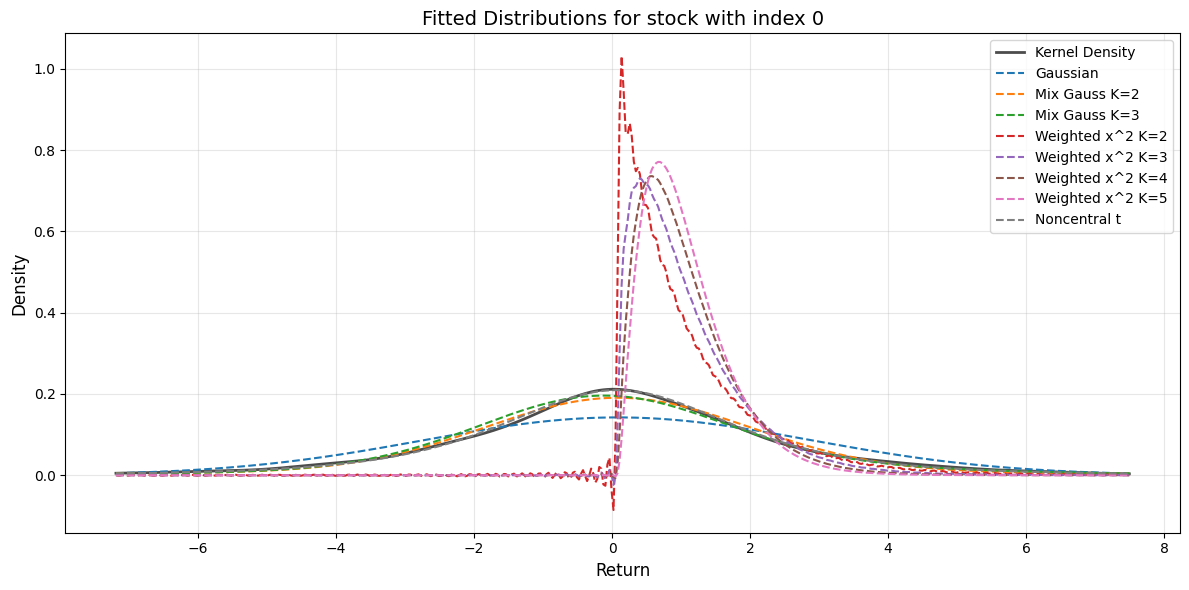

In [ ]:
# Plot for first stock

first_stock = returns.columns[0]
data_first = returns[first_stock].values

fig, ax = plt.subplots(figsize=(12, 6))

# Kernel density estimate
from scipy.stats import gaussian_kde
kde = gaussian_kde(data_first)

# Use central 98% of the data for plotting range (1%–99% quantiles)
q_low, q_high = np.quantile(data_first, [0.01, 0.99])
x_range = np.linspace(q_low, q_high, 500)

ax.plot(x_range, kde(x_range), 'k-', linewidth=2,
        label='Kernel Density', alpha=0.7)

# Gaussian
params = all_results[first_stock]['Gaussian']['params']
y = gaussian_pdf(x_range, params[0], params[1])
ax.plot(x_range, y, '--', label='Gaussian', linewidth=1.5)

# Mixture Gaussians
for K, label in [(2, 'Mix Gauss K=2'), (3, 'Mix Gauss K=3')]:
    params = all_results[first_stock][f'MixGauss_K{K}']['params']
    y = mixture_gaussian_pdf(x_range, params, K)
    ax.plot(x_range, y, '--', label=label, linewidth=1.5)

# Weighted Chi-Squared (if fitted successfully)
for K in [2, 3, 4, 5]:
    model_key = f"WeightedChiSq_K{K}"
    if all_results[first_stock][model_key]['params'] is not None:
        params = all_results[first_stock][model_key]['params']
        weights = params[:K]
        location = params[K]
        phi = weighted_chisq_cf_grid(weights, location)
        y = weighted_chisq_pdf_from_phi(x_range, phi)
        ax.plot(x_range, y, '--',
                label=f"Weighted x^2 K={K}", linewidth=1.5)

# NCT
params = all_results[first_stock]['NCT']['params']
y = nct_pdf(x_range, params[0], params[1], params[2], params[3])
ax.plot(x_range, y, '--', label='Noncentral t', linewidth=1.5)

ax.set_xlabel('Return', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Fitted Distributions for stock with index {first_stock}', fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## **5. Model Selection Table**

In [ ]:
# Create summary table
model_selection = []

for stock in returns.columns:
    best_loglik = max(all_results[stock].items(),
                      key=lambda x: x[1]['loglik'])[0]
    best_aic = min(all_results[stock].items(),
                   key=lambda x: x[1]['AIC'])[0]
    best_bic = min(all_results[stock].items(),
                   key=lambda x: x[1]['BIC'])[0]

    model_selection.append({
        'Stock': stock,
        'Best (LogLik)': best_loglik,
        'Best (AIC)': best_aic,
        'Best (BIC)': best_bic
    })

df_selection = pd.DataFrame(model_selection)
print("\nModel Selection Summary:")
print(df_selection.to_string(index=False))



Model Selection Summary:
 Stock Best (LogLik)  Best (AIC)  Best (BIC)
     0           NCT         NCT         NCT
     1   MixGauss_K3 MixGauss_K3 MixGauss_K3
     2   MixGauss_K3         NCT         NCT
     3   MixGauss_K3 MixGauss_K3         NCT
     4           NCT         NCT         NCT
     5           NCT         NCT         NCT
     6           NCT         NCT         NCT
     7           NCT         NCT         NCT
     8   MixGauss_K3         NCT         NCT
     9   MixGauss_K3 MixGauss_K3 MixGauss_K3
    10   MixGauss_K3 MixGauss_K3         NCT
    11           NCT         NCT         NCT
    12           NCT         NCT         NCT
    13           NCT         NCT         NCT
    14           NCT         NCT         NCT
    15           NCT         NCT         NCT
    16           NCT         NCT         NCT
    17   MixGauss_K3 MixGauss_K3         NCT
    18           NCT         NCT         NCT
    19           NCT         NCT         NCT
    20           NCT         

In [ ]:
# ===== LaTeX table for model selection (loglik, AIC, BIC) =====

import pandas as pd

# Optional: pretty names for models
name_map = {
    'Gaussian': 'Gaussian',
    'MixGauss_K2': r'Mix Gauss $K=2$',
    'MixGauss_K3': r'Mix Gauss $K=3$',
    'WeightedChiSq_K2': r'Weighted $\chi^2$, $K=2$',
    'WeightedChiSq_K3': r'Weighted $\chi^2$, $K=3$',
    'WeightedChiSq_K4': r'Weighted $\chi^2$, $K=4$',
    'WeightedChiSq_K5': r'Weighted $\chi^2$, $K=5$',
    'NCT': r'Noncentral $t$'
}

df_sel_latex = df_selection.copy()

for col in ['Best (LogLik)', 'Best (AIC)', 'Best (BIC)']:
    df_sel_latex[col] = df_sel_latex[col].map(name_map).fillna(df_sel_latex[col])

latex_table = df_sel_latex.to_latex(
    index=False,
    escape=False,              # allow LaTeX math in model names
    column_format='lccc',      # 1 left, 3 centered/right columns
    caption=r'Model selection by log-likelihood, AIC and BIC for each stock.',
    label=r'tab:model_selection',
    bold_rows=False
)

print(latex_table)


\begin{table}
\caption{Model selection by log-likelihood, AIC and BIC for each stock.}
\label{tab:model_selection}
\begin{tabular}{lccc}
\toprule
Stock & Best (LogLik) & Best (AIC) & Best (BIC) \\
\midrule
0 & Noncentral $t$ & Noncentral $t$ & Noncentral $t$ \\
1 & Mix Gauss $K=3$ & Mix Gauss $K=3$ & Mix Gauss $K=3$ \\
2 & Mix Gauss $K=3$ & Noncentral $t$ & Noncentral $t$ \\
3 & Mix Gauss $K=3$ & Mix Gauss $K=3$ & Noncentral $t$ \\
4 & Noncentral $t$ & Noncentral $t$ & Noncentral $t$ \\
5 & Noncentral $t$ & Noncentral $t$ & Noncentral $t$ \\
6 & Noncentral $t$ & Noncentral $t$ & Noncentral $t$ \\
7 & Noncentral $t$ & Noncentral $t$ & Noncentral $t$ \\
8 & Mix Gauss $K=3$ & Noncentral $t$ & Noncentral $t$ \\
9 & Mix Gauss $K=3$ & Mix Gauss $K=3$ & Mix Gauss $K=3$ \\
10 & Mix Gauss $K=3$ & Mix Gauss $K=3$ & Noncentral $t$ \\
11 & Noncentral $t$ & Noncentral $t$ & Noncentral $t$ \\
12 & Noncentral $t$ & Noncentral $t$ & Noncentral $t$ \\
13 & Noncentral $t$ & Noncentral $t$ & Noncentral $

## **6. Value-at-Risk Calculations**

In [ ]:
ALPHA = 0.01  # 1% VaR

# ---------- Empirical VaR ----------
def empirical_var(data, alpha=ALPHA):
    """
    Empirical alpha-VaR of returns (quantile of X, typically negative).
    """
    return np.quantile(data, alpha)


# ---------- Gaussian ----------
def var_gaussian(params, alpha=ALPHA):
    mu, sigma = params
    return stats.norm.ppf(alpha, loc=mu, scale=sigma)


# ---------- Gaussian mixture (K components) ----------
def mixture_gaussian_cdf(x, params, K):
    """CDF of K-component Gaussian mixture at scalar x."""
    weights = np.zeros(K)
    weights[:-1] = params[:K-1]
    weights[-1] = 1 - np.sum(weights[:-1])

    mus = params[K-1: 2*K-1]
    sigmas = params[2*K-1: 3*K-1]

    cdf = 0.0
    for i in range(K):
        cdf += weights[i] * stats.norm.cdf(x, loc=mus[i], scale=sigmas[i])
    return cdf


def var_mixture_gaussian(params, K, alpha=ALPHA):
    """alpha-VaR (quantile of returns) for K-component Gaussian mixture."""
    weights = np.zeros(K)
    weights[:-1] = params[:K-1]
    weights[-1] = 1 - np.sum(weights[:-1])
    mus = params[K-1: 2*K-1]
    sigmas = params[2*K-1: 3*K-1]

    mean_approx = np.sum(weights * mus)
    var_approx = np.sum(weights * (sigmas**2 + (mus - mean_approx)**2))
    std_approx = np.sqrt(max(var_approx, 1e-8))

    lo = mean_approx - 10 * std_approx
    hi = mean_approx + 10 * std_approx

    def f(x):
        return mixture_gaussian_cdf(x, params, K) - alpha

    root = optimize.brentq(f, lo, hi)
    return root


# ---------- Weighted chi-square (K components) ----------
def weighted_chisq_cdf_from_phi(x_array, phi):
    """
    CDF via Gil–Pelaez:
    F(x) = 1/2 - (1/pi) ∫_0^∞ Im( e^{-itx} phi(t) / t ) dt
    x_array: shape (n,)
    phi: shape (N_T,)
    """
    x_array = np.asarray(x_array)

    # avoid division by zero at t=0
    t_safe = np.copy(t_grid)
    t_safe[0] = 1e-12

    phase = np.exp(-1j * np.outer(x_array, t_grid))      # (n, N_T)
    integrand = np.imag(phase * phi / t_safe)            # (n, N_T)

    weights = np.ones_like(t_grid)
    weights[0] = weights[-1] = 0.5

    vals = np.sum(integrand * weights, axis=1) * dt
    return 0.5 - vals / np.pi


def var_weighted_chisq(params, K, alpha=ALPHA):
    """
    Deterministic alpha-VaR for weighted chi-square model via CF inversion.
    params: [w1, ..., wK, location]
    VaR is the alpha-quantile of X
    """
    weights = np.asarray(params[:K])
    location = params[K]

    phi = weighted_chisq_cf_grid(weights, location)

    def F(x):
        return weighted_chisq_cdf_from_phi(np.array([x]), phi)[0]

    # CDF at left edge of support
    F_lo = F(location)

    # If F(location) >= alpha, the alpha-quantile is at the boundary
    if not np.isfinite(F_lo):
        return np.nan
    if F_lo >= alpha:
        return location

    # Otherwise, find hi such that F(hi) > alpha
    hi = location + 1.0
    F_hi = F(hi)
    n_expand = 0
    while F_hi < alpha and n_expand < 20:
        hi = location + 2.0 * (hi - location)
        F_hi = F(hi)
        n_expand += 1

    # pathological case, just return hi as an upper bound
    if F_hi < alpha:
        return hi

    def f(q):
        return F(q) - alpha

    root = optimize.brentq(f, location, hi)
    return root


# ---------- Noncentral t (location–scale) ----------
def var_nct(params, alpha=ALPHA):
    df, nc, loc, scale = params
    q_std = stats.nct.ppf(alpha, df, nc)
    return loc + scale * q_std


In [ ]:
def compute_var(data, model_results, alpha=ALPHA):
    """
    data: 1D np.array of returns
    model_results: all_results[stock] dict
    Returns: dict { 'Empirical': VaR, 'Gaussian': VaR, ... }
    VaR is the alpha-quantile of returns (lecture-note definition).
    """
    var_dict = {}
    var_dict['Empirical'] = empirical_var(data, alpha=alpha)

    for name, res in model_results.items():
        params = res['params']
        if params is None:
            var_dict[name] = np.nan
            continue

        if name == 'Gaussian':
            var_dict[name] = var_gaussian(params, alpha)

        elif name.startswith('MixGauss_K'):
            K = int(name.split('K')[1])
            var_dict[name] = var_mixture_gaussian(params, K, alpha)

        elif name.startswith('WeightedChiSq_K'):
            K = int(name.split('K')[1])
            var_dict[name] = var_weighted_chisq(params, K, alpha)

        elif name == 'NCT':
            var_dict[name] = var_nct(params, alpha)

        else:
            var_dict[name] = np.nan

    return var_dict

In [ ]:
# Create summary table

var_table = []

for stock in returns.columns:
    data = returns[stock].values
    var_dict = compute_var(data, all_results[stock], alpha=ALPHA)

    emp_var = var_dict['Empirical']
    model_names = [m for m in var_dict.keys() if m != 'Empirical']
    diffs = {m: abs(var_dict[m] - emp_var) for m in model_names}
    best_model = min(diffs.items(), key=lambda x: x[1])[0]

    row = {'Stock': stock,
           'Empirical_VaR': emp_var,
           'Best_Model_VaR': best_model}
    for m in model_names:
        row[f'VaR_{m}'] = var_dict[m]

    var_table.append(row)

df_var = pd.DataFrame(var_table)
print("\nVaR(1%) table (VaR = 1% quantile of returns):")
print(df_var.to_string(index=False))



VaR(1%) table (VaR = 1% quantile of returns):
 Stock  Empirical_VaR Best_Model_VaR  VaR_Gaussian  VaR_MixGauss_K2  VaR_MixGauss_K3  VaR_WeightedChiSq_K2  VaR_WeightedChiSq_K3  VaR_WeightedChiSq_K4  VaR_WeightedChiSq_K5   VaR_NCT
     0      -7.189378            NCT     -6.447218        -8.498830        -7.602079              0.078523              0.105452              0.137037              0.170087 -7.411675
     1      -5.855355    MixGauss_K3     -5.130136        -6.856149        -6.001579              0.043948              0.070877              0.102462              0.135512 -6.502200
     2      -5.655318            NCT     -4.844718        -6.541988        -5.560402              0.037785              0.064715              0.096300              0.129350 -5.600945
     3      -5.522085    MixGauss_K3     -4.663411        -5.331057        -5.481870              0.050535              0.077465              0.109050              0.142100 -5.427134
     4      -4.082319            NCT  

In [ ]:
# ===== Build LaTeX VaR table: rows = models, columns = stocks =====

# 1) Identify stocks and model columns
stocks = df_var['Stock'].tolist()

# All columns that contain VaR values, excluding 'Best_Model_VaR' if present
var_cols = [c for c in df_var.columns
            if ('VaR' in c and c != 'Best_Model_VaR')]

# Separate empirical and model VaRs
emp_col = 'Empirical_VaR'
model_cols = [c for c in var_cols if c != emp_col]

# 2) Decide display labels for rows (LaTeX names)
row_labels = {
    'Empirical_VaR': r'Empirical',
    'VaR_Gaussian': r'Gaussian',
    'VaR_MixGauss_K2': r'Mix Gauss $K=2$',
    'VaR_MixGauss_K3': r'Mix Gauss $K=3$',
    'VaR_WeightedChiSq_K2': r'Weighted $\chi^2$, $K=2$',
    'VaR_WeightedChiSq_K3': r'Weighted $\chi^2$, $K=3$',
    'VaR_WeightedChiSq_K4': r'Weighted $\chi^2$, $K=4$',
    'VaR_WeightedChiSq_K5': r'Weighted $\chi^2$, $K=5$',
    'VaR_NCT': r'Noncentral $t$'
}

def get_row_label(colname):
    return row_labels.get(colname, colname.replace('_', r'\_'))

# 3) For each stock, find the model VaR closest to empirical VaR
closest_model_for_stock = {}  # stock -> model_col
for _, row in df_var.iterrows():
    stock = row['Stock']
    emp = row[emp_col]
    best_model = None
    best_diff = np.inf
    for mc in model_cols:
        val = row[mc]
        if np.isnan(val):
            continue
        diff = abs(val - emp)
        if diff < best_diff:
            best_diff = diff
            best_model = mc
    closest_model_for_stock[stock] = best_model

# 4) Build LaTeX table string
latex_lines = []

# Column specification: 1 left (model) + one 'r' per stock
col_spec = 'l' + 'r' * len(stocks)

latex_lines.append(r'\begin{table}[ht]')
latex_lines.append(r'\centering')
latex_lines.append(r'\small')
latex_lines.append(r'\begin{tabular}{' + col_spec + r'}')
latex_lines.append(r'\toprule')

# Header row
header = ['Model'] + [str(s) for s in stocks]
latex_lines.append(' & '.join(header) + r' \\')
latex_lines.append(r'\midrule')

# Helper to format a number
def fmt(x):
    if np.isnan(x):
        return r'--'
    return f'{x:.3f}'

# 4a) Empirical row (first)
row_vals = []
row_vals.append(get_row_label(emp_col))
for _, row in df_var.iterrows():
    row_vals.append(fmt(row[emp_col]))
latex_lines.append(' & '.join(row_vals) + r' \\')

# 4b) Model rows
for mc in model_cols:
    row_vals = []
    row_vals.append(get_row_label(mc))
    for _, row in df_var.iterrows():
        stock = row['Stock']
        val = row[mc]
        s = fmt(val)
        # Bold if this model is closest to empirical for this stock
        if closest_model_for_stock[stock] == mc and s != r'--':
            s = r'\textbf{' + s + '}'
        row_vals.append(s)
    latex_lines.append(' & '.join(row_vals) + r' \\')

latex_lines.append(r'\bottomrule')
latex_lines.append(r'\end{tabular}')
latex_lines.append(r'\caption{1\% VaR (returns) for each stock and model. '
                   r'Empirical VaR in first row; bold values indicate the model '
                   r'closest to the empirical VaR for each stock.}')
latex_lines.append(r'\label{tab:var_1pct}')
latex_lines.append(r'\end{table}')

# 5) Print LaTeX code
latex_table = '\n'.join(latex_lines)
print(latex_table)


\begin{table}[ht]
\centering
\small
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
Model & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 & 14 & 15 & 16 & 17 & 18 & 19 & 20 & 21 & 22 & 23 & 24 \\
\midrule
Empirical & -7.189 & -5.855 & -5.655 & -5.522 & -4.082 & -4.890 & -5.309 & -4.879 & -6.617 & -3.608 & -6.245 & -3.795 & -4.015 & -4.194 & -4.547 & -5.399 & -5.335 & -4.519 & -3.603 & -4.584 & -4.729 & -4.184 & -4.795 & -4.307 & -4.214 \\
Gaussian & -6.447 & -5.130 & -4.845 & -4.663 & -3.801 & -4.330 & -4.551 & -4.026 & -5.541 & -3.103 & -5.458 & -3.245 & -3.506 & -3.385 & -3.900 & -4.580 & -4.691 & -3.863 & -3.256 & -4.232 & -4.018 & -3.524 & -4.170 & -3.733 & -3.570 \\
Mix Gauss $K=2$ & -8.499 & -6.856 & -6.542 & -5.331 & -4.721 & -5.524 & -5.940 & -5.302 & -7.140 & -3.869 & -7.300 & -4.184 & -4.414 & -4.458 & -5.102 & -5.734 & -5.972 & -4.661 & -4.346 & -5.888 & -5.504 & -4.392 & -5.172 & -4.682 & -4.580 \\
Mix Gauss $K=3$ & -7.602 & \textbf{-6.002} & -5.560 & \text